
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/012_LLM_Temperature.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/12_LLM_Temperature.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🌡️ Temperatura w LLM (Odwaga vs Precyzja)

Kiedy używasz API OpenAI lub lokalnych modeli, "Temperature" to najważniejszy suwak.
Często słyszysz:
*   *Do kodowania ustaw T=0.*
*   *Do pisania wierszy ustaw T=0.8.*

Dlaczego?

Model na wyjściu produkuje tzw. **Logity** (surowe punkty dla każdego słowa).
Temperatura to dzielnik w równaniu matematycznym (Softmax), który zmienia te punkty:
1.  **Niska Temperatura (<1):** Wyostrza różnice. Faworyt bierze wszystko. (Pewność siebie).
2.  **Wysoka Temperatura (>1):** Spłaszcza różnice. Słabe słowa zyskują szansę. (Kreatywność / Chaos).

Zrobimy symulację tego mechanizmu.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. SYMULACJA SYTUACJI
# Model kończy zdanie: "Niebo jest..."
# Mamy 4 kandydatów z surowymi punktami (Logits):
slowa = ['Niebieskie', 'Szare', 'Ciemne', 'Zielone']
logits = np.array([10.0, 8.0, 4.0, 1.0]) 

# Zauważ:
# "Niebieskie" ma 10 pkt (Faworyt)
# "Zielone" ma 1 pkt (Bzdura, ale czasem występuje w piosenkach)

print("--- SUROWE PUNKTY (LOGITS) ---")
for s, l in zip(slowa, logits):
    print(f"{s}: {l}")

--- SUROWE PUNKTY (LOGITS) ---
Niebieskie: 10.0
Szare: 8.0
Ciemne: 4.0
Zielone: 1.0


## Matematyka Temperatury (Softmax)

Wzór na prawdopodobieństwo z temperaturą ($T$) wygląda tak:
$$ P_i = \frac{e^{logit_i / T}}{\sum e^{logit_j / T}} $$

Brzmi strasznie, ale robi prostą rzecz:
1.  Dzieli punkty przez $T$.
2.  Potęguje wynik (to sprawia, że duże liczby stają się gigantyczne).

Zdefiniujmy funkcję i zobaczmy 3 scenariusze:
*   **T = 0.5** (Zimny, konserwatywny)
*   **T = 1.0** (Standardowy, neutralny)
*   **T = 2.0** (Gorący, szalony)

In [3]:
def softmax_with_temperature(logits, T):
    # Zabezpieczenie przed dzieleniem przez zero
    if T <= 0: T = 0.0001
    
    # KROK 1: Podziel przez temperaturę
    scaled_logits = logits / T
    
    # KROK 2: Potęgowanie (exp) - żeby zamienić to na prawdopodobieństwa
    # (Odejmujemy max, żeby nie wysadzić pamięci komputera przy dużych liczbach - trick numeryczny)
    exp_logits = np.exp(scaled_logits - np.max(scaled_logits))
    
    # KROK 3: Normalizacja (żeby suma wynosiła 100%)
    probabilities = exp_logits / np.sum(exp_logits)
    return probabilities

# Obliczamy dla różnych temperatur
probs_low = softmax_with_temperature(logits, T=0.1)  # Bardzo niska
probs_med = softmax_with_temperature(logits, T=1.0)  # Standard
probs_high = softmax_with_temperature(logits, T=3.0) # Bardzo wysoka

# Przygotujmy dane do wykresu
df_viz = pd.DataFrame({
    'Słowo': slowa * 3,
    'Prawdopodobieństwo': np.concatenate([probs_low, probs_med, probs_high]),
    'Temperatura': ['T=0.1 (Zimny)']*4 + ['T=1.0 (Baza)']*4 + ['T=3.0 (Gorący)']*4
})

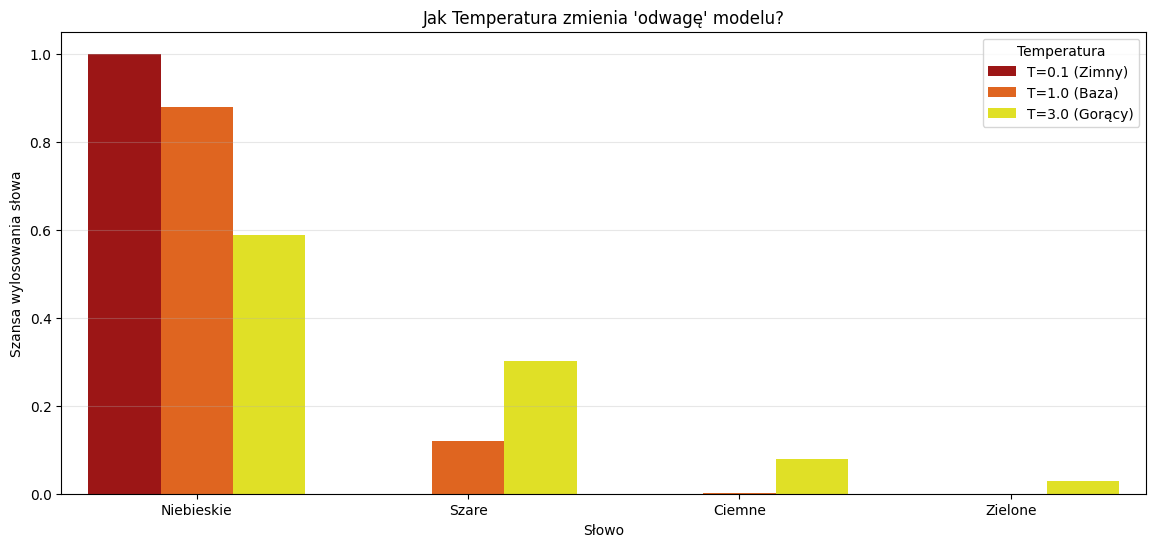

ANALIZA:
Przy T=0.1 szansa na 'Niebieskie': 100.00% (Prawie pewne)
Przy T=3.0 szansa na 'Niebieskie': 58.87% (Ledwo wygrywa)
Przy T=3.0 szansa na 'Zielone':    2.93% (Nagle możliwe!)


In [4]:
# Rysujemy wykresy porównawcze
plt.figure(figsize=(14, 6))
sns.barplot(data=df_viz, x='Słowo', y='Prawdopodobieństwo', hue='Temperatura', palette='hot')

plt.title("Jak Temperatura zmienia 'odwagę' modelu?")
plt.ylabel("Szansa wylosowania słowa")
plt.grid(axis='y', alpha=0.3)
plt.show()

print("ANALIZA:")
print(f"Przy T=0.1 szansa na 'Niebieskie': {probs_low[0]*100:.2f}% (Prawie pewne)")
print(f"Przy T=3.0 szansa na 'Niebieskie': {probs_high[0]*100:.2f}% (Ledwo wygrywa)")
print(f"Przy T=3.0 szansa na 'Zielone':    {probs_high[3]*100:.2f}% (Nagle możliwe!)")

## 🧠 Podsumowanie: Pokrętło Halucynacji

Spójrz na słupki powyżej.

1.  **T=0.1 (Ciemny słupek):** Model widzi tylko jedno rozwiązanie ("Niebieskie"). Reszta nie istnieje.
    *   *Zastosowanie:* Matematyka, Kodowanie, Wyciąganie danych z faktur. (Chcemy fakty, a nie fantazje).
2.  **T=3.0 (Jasny słupek):** Słupki się wyrównują. "Niebieskie" jest tylko trochę lepsze od bzdurnego "Zielone".
    *   *Efekt:* Model zaczyna "gadać głupoty" albo być "bardzo kreatywny" (zależy jak na to patrzysz).

**Tu jest haczyk.**
Wysoka temperatura nie dodaje inteligencji. Ona dodaje **szum**.
Jeśli model nie zna odpowiedzi, niska temperatura sprawi, że powie "Nie wiem" (lub powtórzy najczęstszy błąd). Wysoka temperatura sprawi, że zacznie zmyślać (halucynować) barwne historie, bo matematycznie pozwoliliśmy mu wylosować słowa, które normalnie by odrzucił.

**Wniosek inżynierski:**
Zawsze zaczynaj od `Temperature=0`. Podnoś ją tylko wtedy, gdy czujesz, że model jest zbyt "sztywny" i powtarzalny.